In [1]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sys 
import os
import yaml
from matplotlib.colors import LogNorm, Normalize

from netCDF4 import Dataset
import cartopy.crs as ccrs
import glob
import itertools
from pyproj.crs import CRS

In [2]:
os.chdir('/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion')
from Inference.inference import sample, save_plot, load_image,load_model 
from Visualization.plot import plot_tensors
from Sampling.diffusion_constants import DiffusionConstants
from Sampling.sample import extract

In [3]:
def load_config(path):
    """
    Load the configuration file from the given path.
    """
    print(f"📄 Loading configuration from: {path}")
    with open(path, "r") as f:
        return yaml.safe_load(f)

In [4]:
config_dir ="/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/_Runs/configs/e4_config.yaml" 
image_dir="/net/nfs/ssd3/cfrancoismartin/Projects/datasets/fused_dataset/dataset/2020/sevmos_2020-12-31_13:25:00_17.npy" 
full_image = '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/sevmos_2019-08-09_18:10:00.nc'
#image_dir =""
config = load_config(config_dir)

📄 Loading configuration from: /net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/_Runs/configs/e4_config.yaml


In [5]:
def extraction(file,treshold = 0.01) :
    nc = Dataset(file) # reading the nc file and creating Dataset

    data = {
        'WV_062': nc['WV_062'][:],  # float32 (y, x)
        'WV_073': nc['WV_073'][:],  # float32 (y, x)
        'IR_087': nc['IR_087'][:],  # float32 (y, x)
        'IR_097': nc['IR_097'][:],  # float32 (y, x)
        'IR_108': nc['IR_108'][:],  # float32 (y, x)
        'IR_120': nc['IR_120'][:],  # float32 (y, x)
        'IR_134': nc['IR_134'][:],  # float32 (y, x)
        'rain_rate': nc['rain_rate'],  # float32 (x, y)
        'rain_quality': nc['rain_quality'][:]  # int32 (x, y)
    }

    #print(data)
    lower, upper = data['rain_rate'].valid_range
    fill_value = data['rain_rate'].missing_value
    
    # Ensure valid_range is compatible with the rain_rate type (convert to float if needed)
    lower = float(lower)  # Convert to float to match the rain_rate's type (float32)
    upper = float(upper)  # Convert to float to match the rain_rate's type (float32)
    
    # Extract rain_rate data and apply the valid_range filter
    rain_rate =  data['rain_rate'][:]

    # Apply the valid range filter: values outside this range will be replaced with NaN
    data['rain_rate'] = np.where((rain_rate >= 0.0) & (rain_rate <= upper), rain_rate,np.nan)

    nc.close()
    #data = np.array(data)
    return data 

def extract_npy(fp):
    """
    Load the .npy file while allowing object arrays.
    
    Parameters:
    - fp: str, path to the .npy file

    Returns:
    - data: Loaded numpy array or dictionary
    """

    return np.load(fp, allow_pickle=True).item()


def radar_quality(data,quality_treshold = 0 ):
        data['rain_rate'] = np.where(data['rain_quality']< quality_treshold,np.nan, data['rain_rate'])
        data['rain_rate'] = np.where(data['rain_quality']> 100,np.nan, data['rain_rate'])
        return data


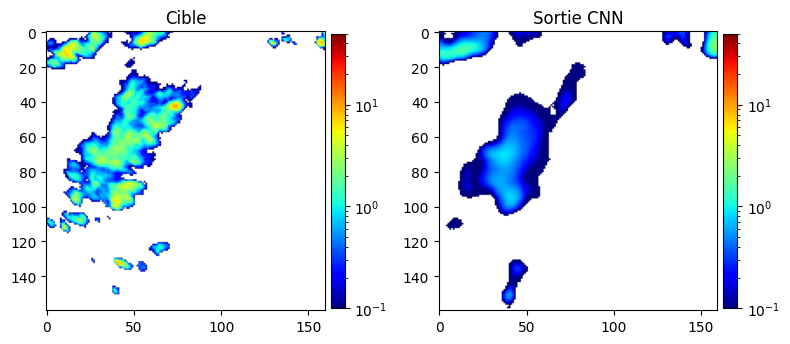

In [6]:
device =  torch.device('cpu')
tb, r, rq = load_image(image_dir, config["list_channels"], device=device)

img = plot_tensors(tb[-1].unsqueeze(0), r, None,None, tb_normalised_nb_sigmas=0)
fig, axes = plt.subplots(1, 2, figsize=(8, 8))  # 1 row, 2 columns

# Define shared normalization
norm = LogNorm(vmin=0.1, vmax=50)

# First image: tb[-1]
im0 = axes[1].imshow(tb[-1], cmap="jet", norm=norm)
axes[1].set_title("Sortie CNN")
fig.colorbar(im0, ax=axes[1], fraction=0.046, pad=0.02)

# Second image: r.squeeze()
im1 = axes[0].imshow(r.squeeze(), cmap="jet", norm=norm)
axes[0].set_title("Cible")
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.02)
plt.subplots_adjust(wspace=0)  #
plt.tight_layout()
plt.show()



/tmp/ipykernel_1007855/1167720708.py:25: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  rain_rate =  data['rain_rate'][:]


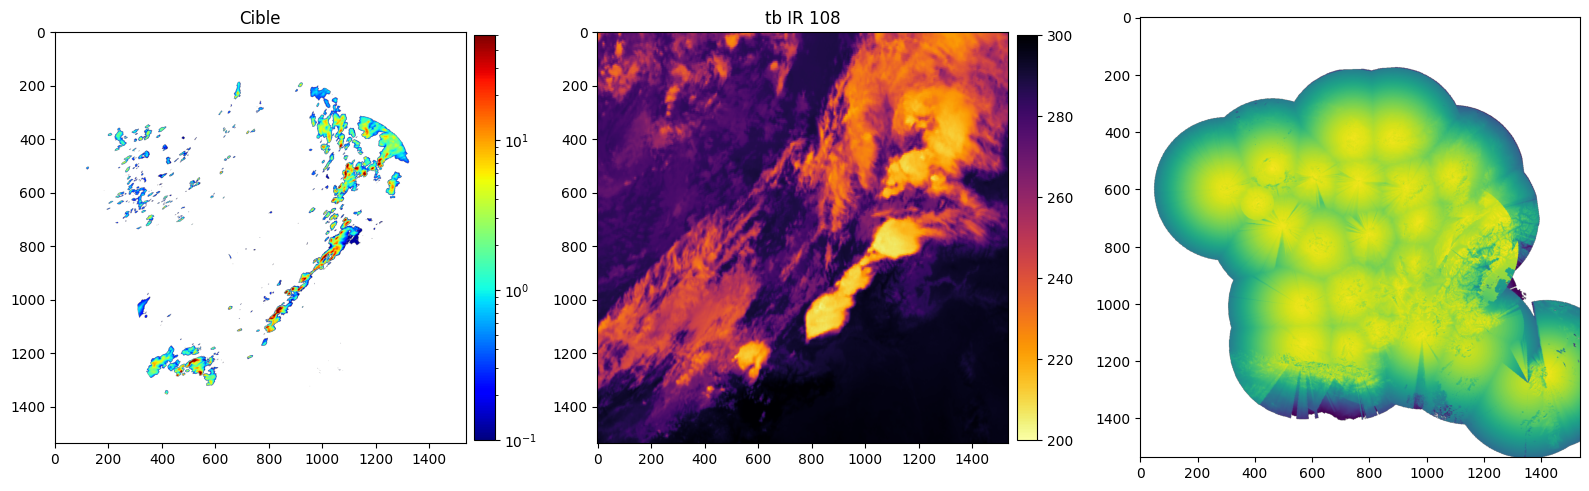

In [7]:
data_full = extraction(full_image)
data_full = radar_quality(data_full)

tb_full = torch.tensor(data_full['IR_108'], device=device)
r_full = torch.tensor(data_full['rain_rate'], device=device)
rq_full = torch.tensor(data_full['rain_quality'], device=device)

cnn_np = np.load("/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/cnn_tensor.npy")
diffusion_np = np.load("/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/diffusion_tensor.npy")
# Convert numpy array to tensor
sampled_cnn_full = torch.from_numpy(cnn_np)
sampled_full = torch.from_numpy(diffusion_np)
img = plot_tensors(tb_full.unsqueeze(0), r_full, None,None, tb_normalised_nb_sigmas=0)
fig, axes = plt.subplots(1, 3, figsize=(16, 16))  # 1 row, 2 columns

# Define shared normalization
norm = LogNorm(vmin=0.1, vmax=50)

# First image: tb[-1]
im0 = axes[1].imshow(tb_full, cmap="inferno_r", vmin = 200, vmax = 300)
axes[1].set_title("tb IR 108")
fig.colorbar(im0, ax=axes[1], fraction=0.046, pad=0.02)

# Second image: r.squeeze()
im1 = axes[0].imshow(r_full.squeeze(), cmap="jet", norm=norm)
axes[0].set_title("Cible")
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.02)


# Mask values outside [0, 100]
# Ensure rq_full is a NumPy array
rq_full = np.array(rq_full, dtype=float)

rq_full[(rq_full < 0) | (rq_full > 100)] = np.nan
im2 = axes[2].imshow(rq_full.squeeze(), cmap="viridis", vmin=0, vmax=100)
axes[0].set_title("Cible")
plt.subplots_adjust(wspace=0)  #
plt.tight_layout()
plt.show()


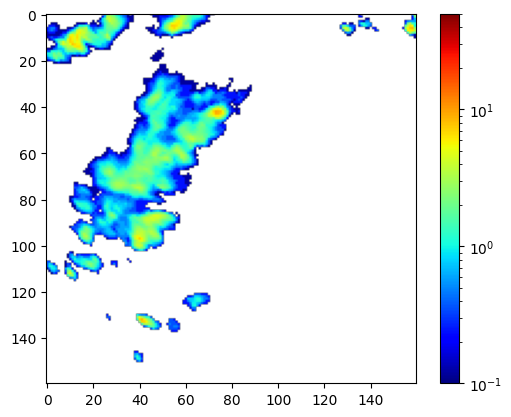

In [8]:
plt.imshow(r.squeeze(), cmap="jet", norm=norm)

plt.colorbar()

plt.show()

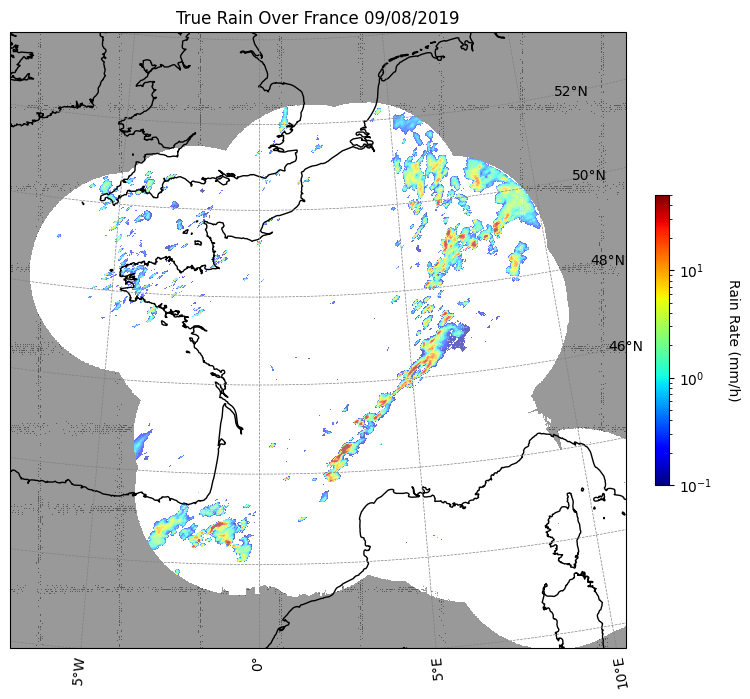

In [45]:
# File path to base NetCDF data
file_path = '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/grid_france_1536-1km_200906110000-219912310000.nc'

# Open the NetCDF file
with Dataset(file_path) as dataset:
    latitude = dataset.variables['latitude'][:]  
    longitude = dataset.variables['longitude'][:]  

#print(f"longitude : {longitude}, latitude : {latitude}")
# Create a figure
fig, ax = plt.subplots(figsize=(10, 8),subplot_kw={'projection': ccrs.Stereographic(central_longitude=0, central_latitude=90)})

# Plot the data with logarithmic normalization
p = ax.pcolormesh(longitude, latitude, np.transpose(r_full.squeeze()), cmap='jet', shading="auto",
                    transform=ccrs.PlateCarree(),norm = LogNorm(vmin=0.1, vmax=50))

# Add map features
ax.coastlines()

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right labels

plt.title('True Rain Over France 09/08/2019')

# Adjust the layout to make space for the colorbar
fig.subplots_adjust(right=0.85)  # Reduce the space for the plot on the right

# Add the colorbar with adjusted size and position
cbar = fig.colorbar(p, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Rain Rate (mm/h)', rotation=270, labelpad=20)


# Ensure rq_full is a NumPy array
rq_full = np.array(rq_full, dtype=float)

# Mask values outside [0, 100]
rq_full[(rq_full < 0) | (rq_full > 100)] = np.nan
# Create a mask where rq_full is NaN
nan_mask = np.isnan(rq_full.squeeze())

# Convert mask to float (1 where NaN, 0 elsewhere)
mask_data = nan_mask.astype(float)

# Overlay the mask with translucency
# Use the same coordinates as your data, with a grayscale colormap or custom translucent color
ax.pcolormesh(longitude, latitude, np.transpose(mask_data), cmap='Greys', alpha=0.4, shading='auto', transform=ccrs.PlateCarree())

# Save the plot
file_name = 'august_2019'
output_path = f"/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/r_full.png"
plt.savefig(output_path, dpi=300)  # Save with high resolution

# Optionally, show the plot
plt.show()

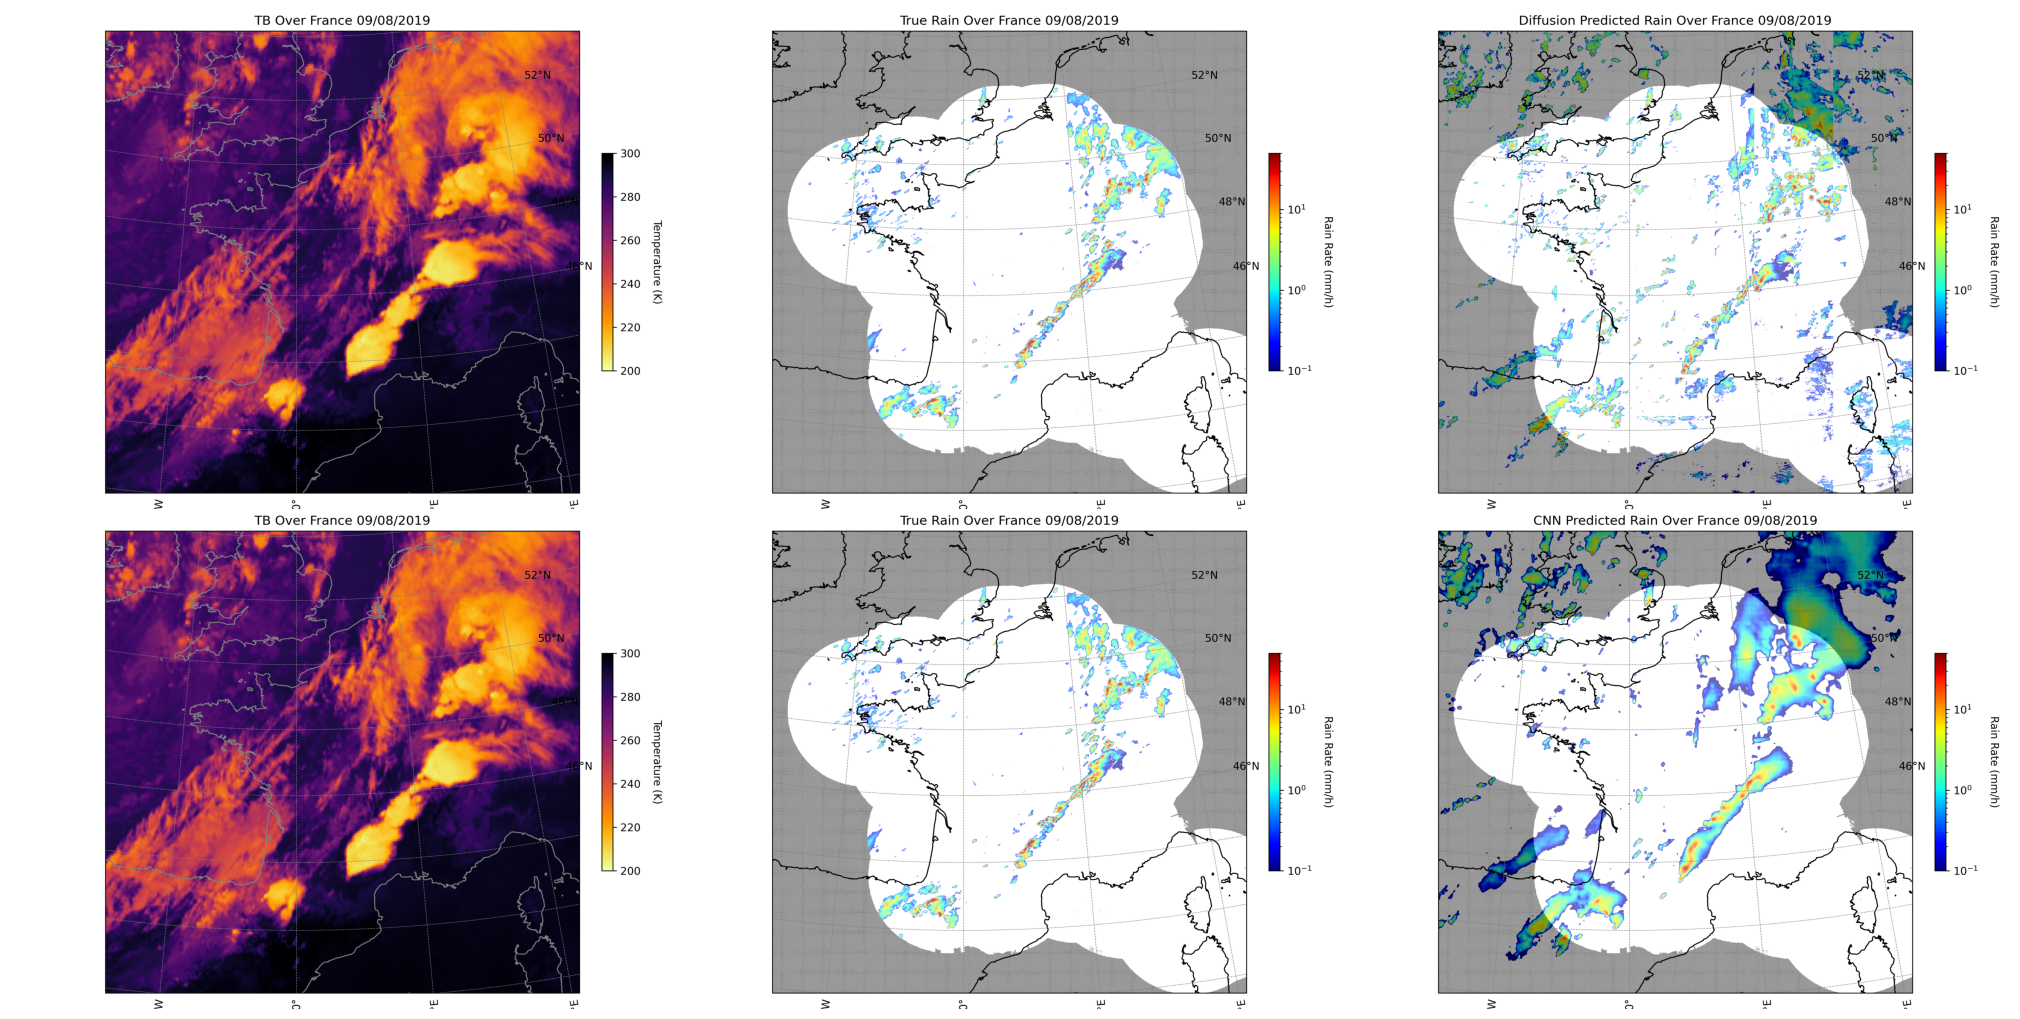

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

def crop_images(png_paths, crop_pixels):
    cropped_images = []
    for path in png_paths:
        img = Image.open(path)
        width, height = img.size
        # Define the crop box (left, upper, right, lower)
        crop_box = (
            crop_pixels,              # left
            crop_pixels,              # upper
            width - crop_pixels,      # right
            height - crop_pixels      # lower
        )
        cropped_img = img.crop(crop_box)
        cropped_images.append(cropped_img)
    return cropped_images

def plot_cropped_image_grid(png_paths, crop_pixels):
    cropped_images = crop_images(png_paths, crop_pixels)
    fig = plt.figure(figsize=(20, 10))
    nrows, ncols = 2, 3
    
    for i, img in enumerate(cropped_images):
        left = (i % ncols) / ncols
        bottom = 1 - (i // ncols + 1) / nrows
        width = 1 / ncols
        height = 1 / nrows
        
        ax = fig.add_axes([left, bottom, width, height])
        ax.imshow(img, aspect='auto')
        ax.axis('off')
        ax.margins(0)
    
    plt.savefig("/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/final_output_cropped.png",
                dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

# Example usage:
png_paths = [
    '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/tb_full.png',
    '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/r_full.png',
    '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/sampled_full.png',
    '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/tb_full.png',
    '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/r_full.png',
    '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/cnn_full.png'
]

plot_cropped_image_grid(png_paths, crop_pixels=200)

def plot_image_grid(png_paths):
    fig = plt.figure(figsize=(20, 10))
    
    nrows, ncols = 2, 3
    for i, png_path in enumerate(png_paths):
        # Calculate position of each subplot as [left, bottom, width, height]
        left = (i % ncols) / ncols
        bottom = 1 - (i // ncols + 1) / nrows
        width = 1 / ncols
        height = 1 / nrows
        
        ax = fig.add_axes([left, bottom, width, height])
        img = mpimg.imread(png_path)
        ax.imshow(img, aspect='auto')
        ax.axis('off')
        ax.margins(0)
    
    plt.savefig("/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/final_output.png",
                dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

# Example usage (same png_paths)


# # Example usage:
# png_paths = [
#     '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/tb_full.png',
#     '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/r_full.png',
#     '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/sampled_full.png',
#     '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/tb_full.png',
    
#     '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/r_full.png',
#     '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/cnn_full.png'
# ]

# plot_image_grid(png_paths)


(1536, 1536)


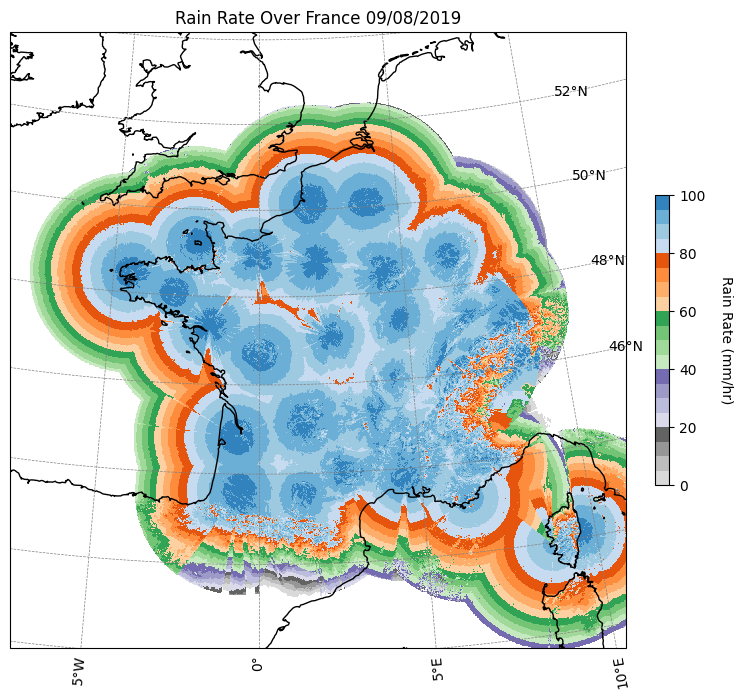

In [10]:
import numpy as np

# Ensure rq_full is a NumPy array
rq_full = np.array(rq_full, dtype=float)

# Mask values outside [0, 100]
rq_full[(rq_full < 0) | (rq_full > 100)] = np.nan

print(rq_full.shape)
# Create a figure
fig, ax = plt.subplots(figsize=(10, 8),
    subplot_kw={'projection': ccrs.Stereographic(central_longitude=0, central_latitude=90)}
)

# Plot the data
p = ax.pcolormesh(longitude, latitude, np.transpose(rq_full.squeeze()),
                  cmap='tab20c_r', shading="auto",
                  transform=ccrs.PlateCarree(), vmax=100)

# Add map features
ax.coastlines()

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False
gl.right_labels = False

plt.title('Rain Rate Over France 09/08/2019')

# Adjust layout
fig.subplots_adjust(right=0.85)

# Add colorbar
cbar = fig.colorbar(p, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Rain Rate (mm/hr)', rotation=270, labelpad=20)

# Save the plot
file_name = 'august_2019'
output_path = f"/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/rq_grid_{file_name}.png"
plt.savefig(output_path, dpi=300)

# Show plot
plt.show()



In [11]:
print("Latitude min/max:", latitude.min(), latitude.max())
print("Latitude first few values:", latitude[:5])
print("Latitude last few values:", latitude[-5:])

Latitude min/max: 39.473001874866895 54.179002573364414
Latitude first few values: [[53.66600255 53.65700255 53.64700255 ... 39.87400189 39.86600189
  39.85700189]
 [53.66800255 53.65800255 53.64900255 ... 39.87500189 39.86700189
  39.85800189]
 [53.66900255 53.66000255 53.65100255 ... 39.87600189 39.86800189
  39.85900189]
 [53.67100255 53.66200255 53.65200255 ... 39.87800189 39.86900189
  39.86000189]
 [53.67300255 53.66300255 53.65400255 ... 39.87900189 39.87000189
  39.86100189]]
Latitude last few values: [[53.07800252 53.06900252 53.05900252 ... 39.49600188 39.48700188
  39.47900188]
 [53.07500252 53.06600252 53.05700252 ... 39.49400188 39.48600188
  39.47700188]
 [53.07300252 53.06400252 53.05500252 ... 39.49300188 39.48400188
  39.47600188]
 [53.07100252 53.06100252 53.05200252 ... 39.49100188 39.48300188
  39.47400187]
 [53.06800252 53.05900252 53.05000252 ... 39.49000188 39.48100188
  39.47300187]]


torch.Size([1, 1, 1536, 1536])  sampled_cnn_full
torch.Size([1, 1536, 1536])  sampled_diffusion_full
torch.Size([1536, 1536])  r_full
torch.Size([1536, 1536])  tb_full
Geographic plot saved to: /net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/comparison_grid_geographic.png


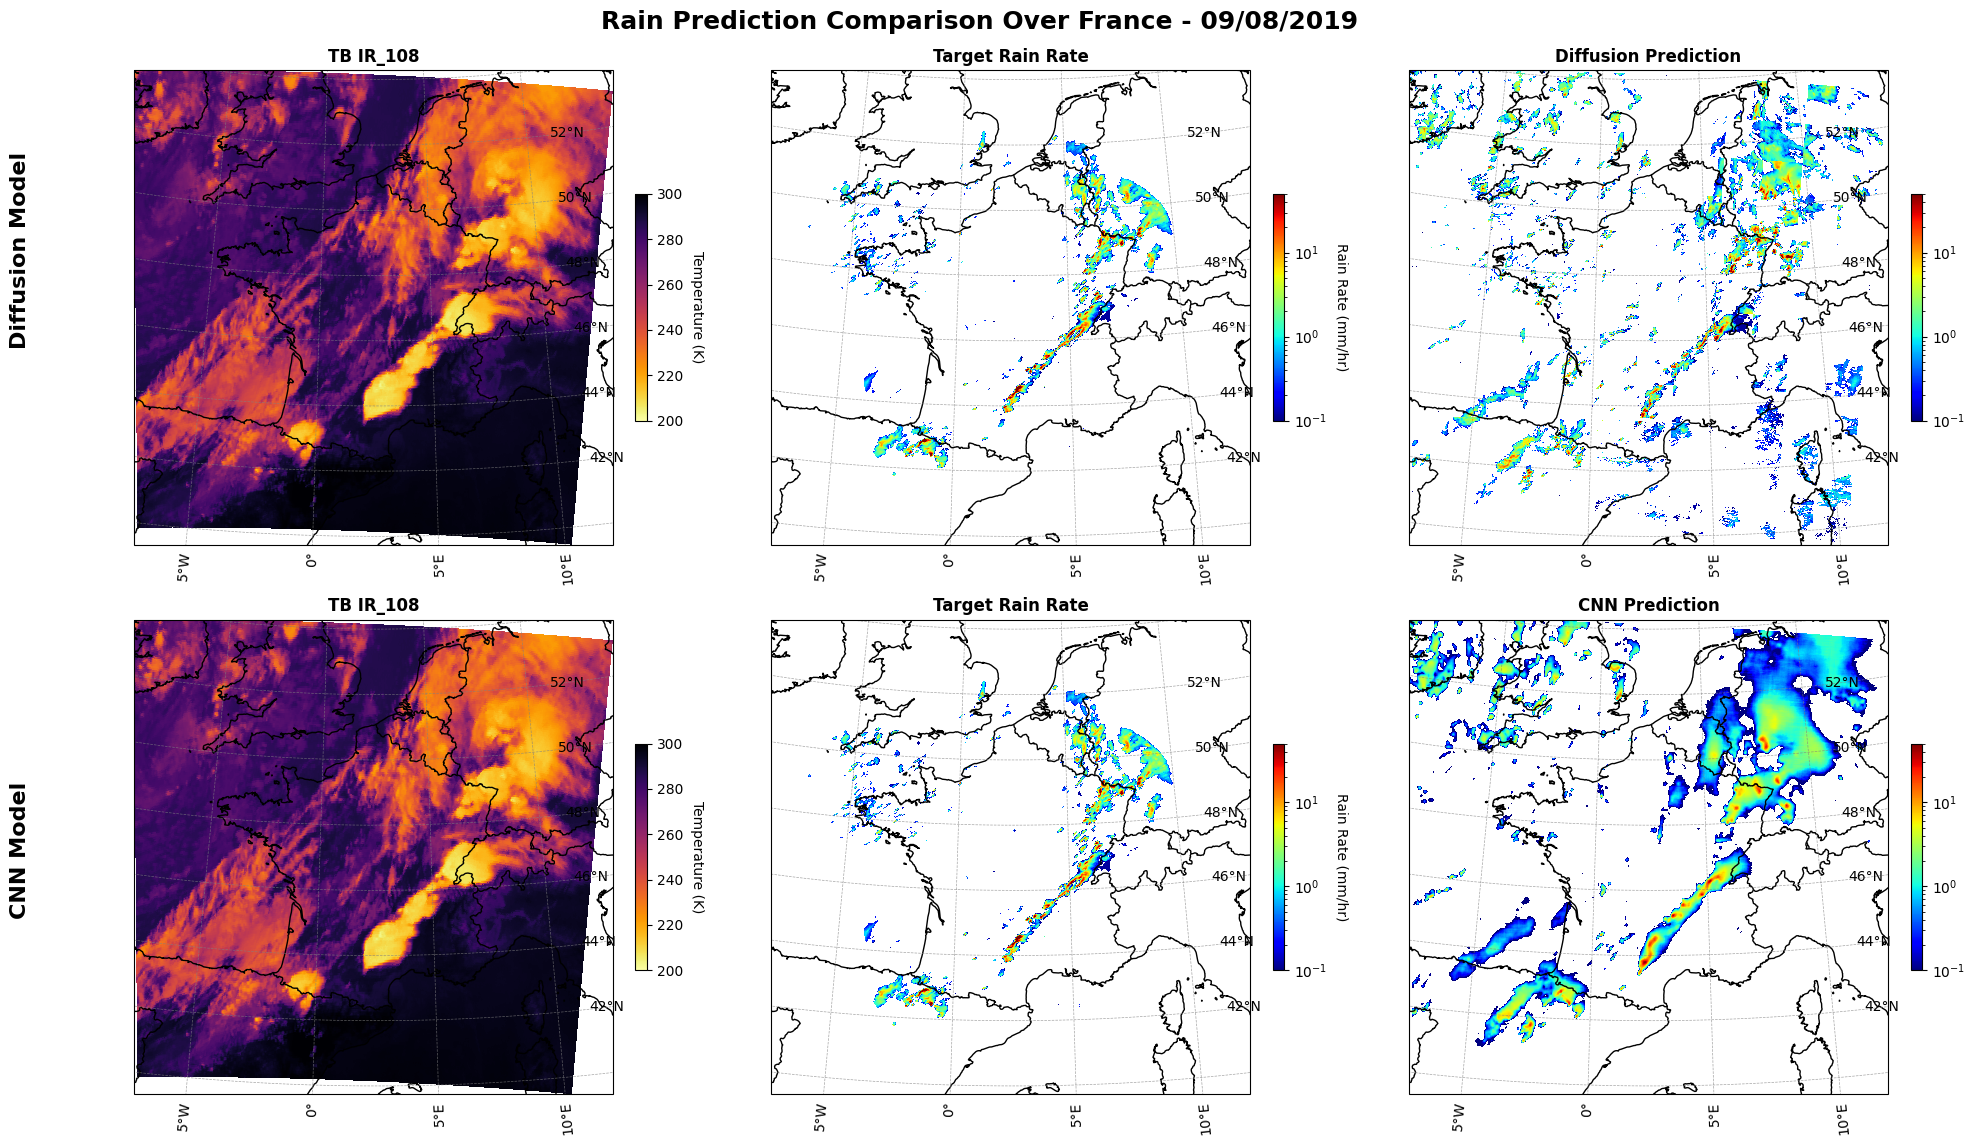

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.colors import LogNorm
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# File path to base NetCDF data
file_path = '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/grid_france_1536-1km_200906110000-219912310000.nc'

# Load your data (assuming these functions and variables are already defined)
# data_full = extraction(full_image)
# data_full = radar_quality(data_full)
# tb_full = torch.tensor(data_full['IR_108'], device=device)
# r_full = torch.tensor(data_full['rain_rate'], device=device)
# rq_full = torch.tensor(data_full['rain_quality'], device=device)

# Load CNN and diffusion results
cnn_np = np.load("/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/cnn_tensor.npy")
diffusion_np = np.load("/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/diffusion_tensor.npy")

# Convert numpy arrays to tensors
sampled_cnn_full = torch.from_numpy(cnn_np)
sampled_diffusion_full = torch.from_numpy(diffusion_np)
print(sampled_cnn_full.shape, " sampled_cnn_full")
print(sampled_diffusion_full.shape, " sampled_diffusion_full")
print(r_full.shape, " r_full")
print(tb_full.shape, " tb_full")

def plot_rain_grid(tb_full, r_full, sampled_diffusion_full, sampled_cnn_full, 
                   save_path=None, title_date="09/08/2019"):
    """
    Plot a 2x3 grid showing:
    Top row: TB, Target, Diffusion
    Bottom row: TB, Target, CNN
    """
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Define normalization for rain data
    rain_norm = LogNorm(vmin=0.1, vmax=50)
    
    # Convert tensors to numpy if needed
    if isinstance(tb_full, torch.Tensor):
        tb_data = tb_full.cpu().numpy()
    else:
        tb_data = tb_full
        
    if isinstance(r_full, torch.Tensor):
        r_data = r_full.cpu().numpy().squeeze()
    else:
        r_data = r_full.squeeze()
        
    if isinstance(sampled_diffusion_full, torch.Tensor):
        diffusion_data = sampled_diffusion_full.cpu().numpy().squeeze()
    else:
        diffusion_data = sampled_diffusion_full.squeeze()
        
    if isinstance(sampled_cnn_full, torch.Tensor):
        cnn_data = sampled_cnn_full.cpu().numpy().squeeze()
    else:
        cnn_data = sampled_cnn_full.squeeze()
    
    # Top row: TB, Target, Diffusion
    # TB IR_108
    im00 = axes[0, 0].imshow(tb_data, cmap="inferno_r", vmin=200, vmax=300)
    axes[0, 0].set_title("TB IR_108", fontsize=14, fontweight='bold')
    fig.colorbar(im00, ax=axes[0, 0], fraction=0.046, pad=0.02)
    
    # Target rain rate
    im01 = axes[0, 1].imshow(r_data, cmap="jet", norm=rain_norm)
    axes[0, 1].set_title("Target Rain Rate", fontsize=14, fontweight='bold')
    cbar01 = fig.colorbar(im01, ax=axes[0, 1], fraction=0.046, pad=0.02)
    cbar01.set_label('Rain Rate (mm/hr)', rotation=270, labelpad=15)
    
    # Diffusion prediction
    im02 = axes[0, 2].imshow(diffusion_data, cmap="jet", norm=rain_norm)
    axes[0, 2].set_title("Diffusion Prediction", fontsize=14, fontweight='bold')
    cbar02 = fig.colorbar(im02, ax=axes[0, 2], fraction=0.046, pad=0.02)
    cbar02.set_label('Rain Rate (mm/hr)', rotation=270, labelpad=15)
    
    # Bottom row: TB, Target, CNN
    # TB IR_108 (repeated)
    im10 = axes[1, 0].imshow(tb_data, cmap="inferno_r", vmin=200, vmax=300)
    axes[1, 0].set_title("TB IR_108", fontsize=14, fontweight='bold')
    fig.colorbar(im10, ax=axes[1, 0], fraction=0.046, pad=0.02)
    
    # Target rain rate (repeated)
    im11 = axes[1, 1].imshow(r_data, cmap="jet", norm=rain_norm)
    axes[1, 1].set_title("Target Rain Rate", fontsize=14, fontweight='bold')
    cbar11 = fig.colorbar(im11, ax=axes[1, 1], fraction=0.046, pad=0.02)
    cbar11.set_label('Rain Rate (mm/hr)', rotation=270, labelpad=15)
    
    # CNN prediction
    im12 = axes[1, 2].imshow(cnn_data, cmap="jet", norm=rain_norm)
    axes[1, 2].set_title("CNN Prediction", fontsize=14, fontweight='bold')
    cbar12 = fig.colorbar(im12, ax=axes[1, 2], fraction=0.046, pad=0.02)
    cbar12.set_label('Rain Rate (mm/hr)', rotation=270, labelpad=15)
    
    # Remove axis ticks for cleaner look
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Add row labels
    axes[0, 0].text(-0.15, 0.5, 'Diffusion Model', transform=axes[0, 0].transAxes, 
                    rotation=90, va='center', ha='center', fontsize=16, fontweight='bold')
    axes[1, 0].text(-0.15, 0.5, 'CNN Model', transform=axes[1, 0].transAxes, 
                    rotation=90, va='center', ha='center', fontsize=16, fontweight='bold')
    
    # Add main title
    fig.suptitle(f'Rain Prediction Comparison - {title_date}', fontsize=18, fontweight='bold', y=0.95)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, left=0.08)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()
    
    return fig, axes

def plot_geographic_grid(longitude, latitude, tb_full, r_full, sampled_diffusion_full, 
                        sampled_cnn_full, save_path=None, title_date="09/08/2019"):
    """
    Plot a 2x3 grid with geographic projection showing:
    Top row: TB, Target, Diffusion
    Bottom row: TB, Target, CNN
    """
    
    # Create figure with geographic projections
    projection = ccrs.Stereographic(central_longitude=2.5, central_latitude=46.5)
    fig = plt.figure(figsize=(20, 12))
    
    # Define normalization for rain data
    rain_norm = LogNorm(vmin=0.1, vmax=50)
    
    # Convert tensors to numpy if needed
    if isinstance(tb_full, torch.Tensor):
        tb_data = tb_full.cpu().numpy()
    else:
        tb_data = tb_full
        
    if isinstance(r_full, torch.Tensor):
        r_data = r_full.cpu().numpy().squeeze()
    else:
        r_data = r_full.squeeze()
        
    if isinstance(sampled_diffusion_full, torch.Tensor):
        diffusion_data = sampled_diffusion_full.cpu().numpy().squeeze()
    else:
        diffusion_data = sampled_diffusion_full.squeeze()
        
    if isinstance(sampled_cnn_full, torch.Tensor):
        cnn_data = sampled_cnn_full.cpu().numpy().squeeze()
    else:
        cnn_data = sampled_cnn_full.squeeze()
    
    # Create subplots with projection
    positions = [(2, 3, 1), (2, 3, 2), (2, 3, 3), (2, 3, 4), (2, 3, 5), (2, 3, 6)]
    
    axes = []
    for i, pos in enumerate(positions):
        ax = fig.add_subplot(*pos, projection=projection)
        axes.append(ax)
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
        gl.top_labels = False
        gl.right_labels = False
    
    # Plot data
    titles = ["TB IR_108", "Target Rain Rate", "Diffusion Prediction", 
              "TB IR_108", "Target Rain Rate", "CNN Prediction"]
    data_list = [tb_data, r_data, diffusion_data, tb_data, r_data, cnn_data]
    cmaps = ["inferno_r", "jet", "jet", "inferno_r", "jet", "jet"]
    norms = [None, rain_norm, rain_norm, None, rain_norm, rain_norm]
    vmins = [200, None, None, 200, None, None]
    vmaxs = [300, None, None, 300, None, None]
    
    for i, (ax, title, data, cmap, norm, vmin, vmax) in enumerate(zip(axes, titles, data_list, cmaps, norms, vmins, vmaxs)):
        if norm is not None:
            p = ax.pcolormesh(longitude, latitude, np.transpose(data), 
                            cmap=cmap, shading="auto", transform=ccrs.PlateCarree(), norm=norm)
        else:
            p = ax.pcolormesh(longitude, latitude, np.transpose(data), 
                            cmap=cmap, shading="auto", transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
        
        ax.set_title(title, fontsize=12, fontweight='bold')
        
        # Add colorbar
        cbar = fig.colorbar(p, ax=ax, orientation='vertical', fraction=0.02, pad=0.04, shrink=0.8)
        if "Rain" in title:
            cbar.set_label('Rain Rate (mm/hr)', rotation=270, labelpad=15)
        elif "TB" in title:
            cbar.set_label('Temperature (K)', rotation=270, labelpad=15)
    
    # Add row labels
    fig.text(0.02, 0.75, 'Diffusion Model', rotation=90, va='center', ha='center', 
             fontsize=16, fontweight='bold')
    fig.text(0.02, 0.25, 'CNN Model', rotation=90, va='center', ha='center', 
             fontsize=16, fontweight='bold')
    
    # Add main title
    fig.suptitle(f'Rain Prediction Comparison Over France - {title_date}', 
                fontsize=18, fontweight='bold', y=0.95)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, left=0.05)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Geographic plot saved to: {save_path}")
    
    plt.show()
    
    return fig, axes

# Example usage:
if __name__ == "__main__":
    # Assuming your data variables are loaded:
    # tb_full, r_full, sampled_diffusion_full, sampled_cnn_full
    
    # Simple grid plot
    output_path_simple = "/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/comparison_grid.png"
    # plot_rain_grid(tb_full, r_full, sampled_diffusion_full, sampled_cnn_full, 
    #                save_path=output_path_simple, title_date="09/08/2019")
    
    # Geographic grid plot (if you have longitude/latitude)
    try:
        with Dataset(file_path) as dataset:
            latitude = dataset.variables['latitude'][:]  
            longitude = dataset.variables['longitude'][:]
        
        output_path_geo = "/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/comparison_grid_geographic.png"
        plot_geographic_grid(longitude, latitude, tb_full, r_full, sampled_diffusion_full, 
                           sampled_cnn_full, save_path=output_path_geo, title_date="09/08/2019")
    except:
        print("Could not load geographic coordinates, skipping geographic plot")

In [13]:
# import matplotlib.pyplot as plt
# import numpy as np
# from netCDF4 import Dataset
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# from matplotlib.colors import LogNorm

# # File path to base NetCDF data
# file_path = '/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/grid_france_1536-1km_200906110000-219912310000.nc'

# # Load lat/lon
# with Dataset(file_path) as dataset:
#     latitude = dataset.variables['latitude'][:]  
#     longitude = dataset.variables['longitude'][:]

# # Make sure lat/lon are 2D for pcolormesh
# if longitude.ndim == 1 and latitude.ndim == 1:
#     lon2d, lat2d = np.meshgrid(longitude, latitude)
# else:
#     lon2d, lat2d = longitude, latitude

# # Prepare data arrays (replace these with your actual variables)
# # tb_full, r_full, sampled_diffusion_full, sampled_cnn_full should be torch or numpy arrays
# tb_data = tb_full.cpu().numpy().squeeze()
# r_data = r_full.cpu().numpy().squeeze()
# diffusion_data = sampled_diffusion_full.cpu().numpy().squeeze()
# cnn_data = sampled_cnn_full.cpu().numpy().squeeze()

# # Create figure with 2x3 subplots
# projection = ccrs.Stereographic(central_longitude=2.5, central_latitude=46.5)
# fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': projection})
# axes = axes.ravel()

# # Data to plot
# data_list = [
#     tb_data, r_data, diffusion_data,
#     tb_data, r_data, cnn_data
# ]
# titles = [
#     "TB IR_108", "Target Rain Rate", "Diffusion Prediction",
#     "TB IR_108", "Target Rain Rate", "CNN Prediction"
# ]
# cmaps = ["inferno_r", "jet", "jet", "inferno_r", "jet", "jet"]
# norms = [None, LogNorm(vmin=0.1, vmax=50), LogNorm(vmin=0.1, vmax=50),
#          None, LogNorm(vmin=0.1, vmax=50), LogNorm(vmin=0.1, vmax=50)]
# vmins = [200, None, None, 200, None, None]
# vmaxs = [300, None, None, 300, None, None]

# # Plot loop
# for ax, data, title, cmap, norm, vmin, vmax in zip(axes, data_list, titles, cmaps, norms, vmins, vmaxs):
#     if longitude.ndim == 1 and latitude.ndim == 1:
#         lon2d, lat2d = np.meshgrid(longitude, latitude)
#     else:
#         lon2d, lat2d = longitude, latitude  # already 2D

#     # plot
#     p = ax.pcolormesh(lon2d, lat2d, data,
#                     cmap='jet', shading="auto",
#                     transform=ccrs.PlateCarree(), norm=LogNorm(vmin=0.1, vmax=50))

#     # zoom to data extent
#     ax.set_extent([lon2d.min(), lon2d.max(), lat2d.min(), lat2d.max()],
#                 crs=ccrs.PlateCarree())
#     ax.coastlines()
#     ax.add_feature(cfeature.BORDERS)
#     ax.set_extent([lon2d.min(), lon2d.max(), lat2d.min(), lat2d.max()], crs=ccrs.PlateCarree())

#     gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray", alpha=0.7)
#     gl.top_labels = False
#     gl.right_labels = False

#     if norm is not None:
#         mesh = ax.pcolormesh(lon2d, lat2d, data, cmap=cmap, shading="auto",
#                              transform=ccrs.PlateCarree(), norm=norm)
#     else:
#         mesh = ax.pcolormesh(lon2d, lat2d, data, cmap=cmap, shading="auto",
#                              transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)

#     ax.set_title(title, fontsize=12, fontweight='bold')
#     cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.046, pad=0.02)
#     if "Rain" in title:
#         cbar.set_label('Rain Rate (mm/hr)', rotation=270, labelpad=15)
#     elif "TB" in title:
#         cbar.set_label('Temperature (K)', rotation=270, labelpad=15)

# # Main title
# fig.suptitle("Rain Rate Over France - 09/08/2019", fontsize=16, fontweight='bold', y=0.95)

# # Save
# file_name = 'august_2019'
# output_path = f"/net/nfs/ssd3/cfrancoismartin/Projects/RainDiffusion/Workbench/grid_{file_name}.png"
# plt.savefig(output_path, dpi=300, bbox_inches='tight')
# plt.show()


In [14]:
# Forward diffusion process: adds noise to the input data 'x_start' according to the diffusion schedule
def q_sample(diffusion_constants, x_start, t, noise=None, timesteps=300):
    diffusion_constants = diffusion_constants
    # Get mean and std for normalization from the denoise model


    x_start = x_start.float()
    # Get diffusion schedule constants
    sqrt_alphas_cumprod = diffusion_constants.sqrt_alphas_cumprod.float()
    sqrt_one_minus_alphas_cumprod = diffusion_constants.sqrt_one_minus_alphas_cumprod.float()
    if noise is None:
        # Generate random noise if not provided
        noise = torch.randn_like(x_start, dtype=torch.float32)
    else:
        noise = noise.float()

    # Extract the appropriate constants for the current timestep
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    # Return the noisy sample
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

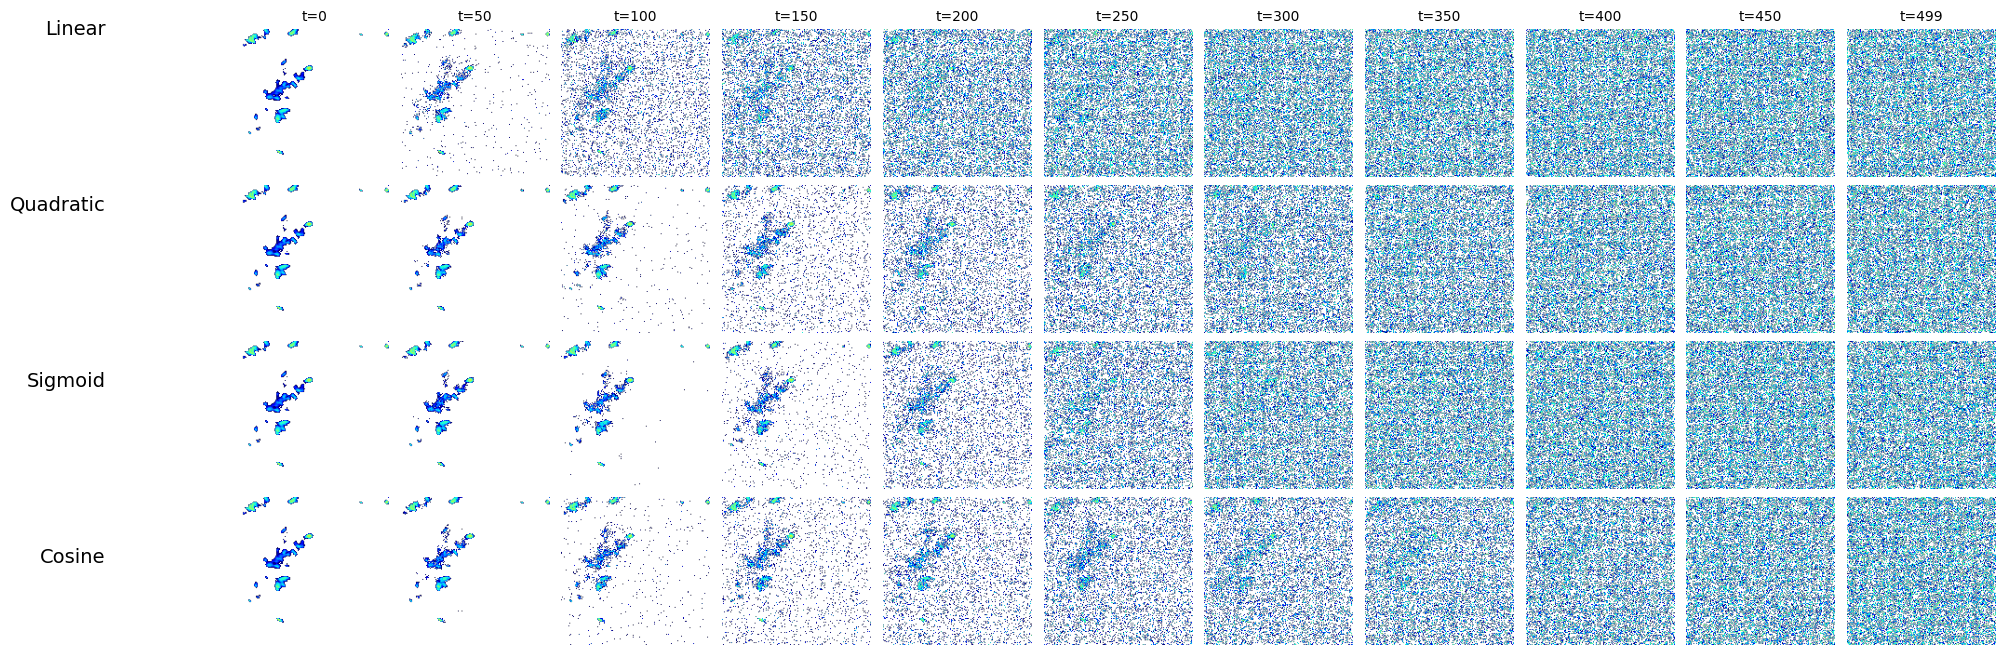

In [15]:
# Set timesteps to visualize (include 499)
timesteps = list(range(0, 500, 50)) + [499]  # [0, 50, ..., 450, 499]

schedulers = {
    'Linear': DiffusionConstants(500, schedule_name='linear', clip_max=0.8),
    'Quadratic': DiffusionConstants(500, schedule_name='quadratic', clip_max=0.8),
    'Sigmoid': DiffusionConstants(500, schedule_name='sigmoid', clip_max=0.8),
    'Cosine': DiffusionConstants(500, schedule_name='cosine', clip_max=0.8)
}

# Prepare figure: 4 rows (schedulers) x 11 columns (timesteps now include 499)
fig, axes = plt.subplots(nrows=4, ncols=len(timesteps), figsize=(22, 8))
x_start = (r.unsqueeze(0) - 1.5501537322998047) / 2.032623291015625 if r.ndim == 3 else r  # Normalize

for row_idx, (name, diffusion_constants) in enumerate(schedulers.items()):
    for col_idx, t_val in enumerate(timesteps):
        t = torch.full((x_start.shape[0],), t_val, dtype=torch.long)
        sample = q_sample(diffusion_constants, x_start, t)
        img = sample[0].permute(1, 2, 0).cpu().numpy()
        if t_val ==200:
            img_save = img
        ax = axes[row_idx, col_idx]
        ax.imshow(img.squeeze(), cmap='jet' if img.shape[-1] == 1 else None, norm=LogNorm(vmin=0.1, vmax=50))
        ax.axis('off')

        if row_idx == 0:
            ax.set_title(f"t={t_val}", fontsize=10)

# Add scheduler names as row labels
for i, name in enumerate(schedulers.keys()):
    fig.text(0.04, 0.88 - i * 0.22, name, fontsize=14, ha='right', va='center', rotation=0)

plt.subplots_adjust(left=0.1, wspace=0.05, hspace=0.05)
plt.show()


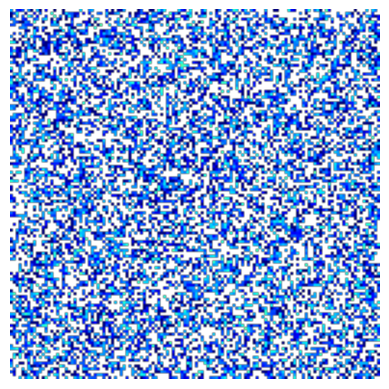

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensions
height, width = 128, 128

# Bruit gaussien : moyenne 0, écart-type 1
noise = np.random.normal(loc=2.032623291015625*0.01, scale=1.5501537322998047*0.3, size=(height, width))

# Affichage
plt.imshow(noise, cmap='jet', norm=norm)
plt.axis('off')
plt.show()

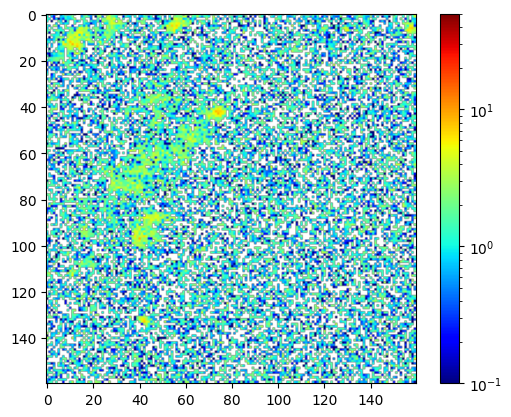

In [17]:
img_save_2 = (img_save*2.032623291015625 + 1.5501537322998047) 
# Define shared normalization
norm = LogNorm(vmin=0.1, vmax=50)
plt.imshow(img_save_2, cmap="jet", norm=norm)

plt.colorbar()

plt.show()